In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter  # Import ScalarFormatter
import uproot
sys.path.append("../")
import saq


Welcome to JupyROOT 6.28/06


In [3]:
# Specify the path to the ROOT file
root_file_path = '/home/wwz/saq_analysis/calibration/08_25_2023_13_45_06.root' 

# Open the ROOT file
file = uproot.open(root_file_path)

# Access the tree from the ROOT file
tree = file["tt"]  # Replace 'tt' with the actual key in your ROOT file

# Convert the tree data into a dictionary
data = tree.arrays(library="np")

ts = data["Timestamp"]
masks = data["ChMask"]

# make a quick way to ensure the channel we want is in the mask
m = lambda ch, mask: 1 << ch & mask

In [4]:
###########################################################################
############# Convert the time of the resets into seconds #################
###########################################################################
# FIXME: move this to saq.py

#clock_rate = saq.CLOCK_FREQ #the frequency of the zybo board
clock_rate = 30.3e6 #the frequency of the zybo board
nn = 0 # number of loops through the clock counter (did it wrap? i.e. when it reaches its max. value and resets to 0)

cutoff = (2**32)-1 # Counter is 32 bits (highest counter value)
loop_time = cutoff/clock_rate # (seconds) Time for counter to wrap

time_sec = np.zeros(len(ts)) #  it initializes an array of zeros with the same length as ts.
#Convert the individual entries to show the time in seconds
for i in range(len(ts)):
    time_sec[i] = ts[i]/clock_rate + (nn*loop_time) #the actual conversion 
    #add a count to the number of loops if the time has reset and fix that value
    if (int(ts[i]) - int(ts[i-1])) < 0 and i !=0:
         nn+=1
         time_sec[i] = float(ts[i]/clock_rate) + float(nn*loop_time) #the actual conversion
total_run = time_sec[-1] # The last element in the data array

print("Total runtime is: ", total_run, "seconds")

Total runtime is:  414.7303994389439 seconds


ch 1  ,mean:  0.00036901128384021845  ,std:  0.00016648143589774635
ch 2  ,mean:  0.00021628233810862867  ,std:  8.33140965029728e-05
ch 3  ,mean:  0.0002891275770474846  ,std:  0.0001242314031718103
ch 4  ,mean:  0.00042649187566837823  ,std:  0.00021546876708805794
ch 5  ,mean:  0.0004413360644456993  ,std:  0.00016616651711651048
ch 6  ,mean:  0.0005129189846965971  ,std:  0.0001850856389003861
ch 7  ,mean:  0.0003165728549834439  ,std:  0.00017363761392735988
ch 8  ,mean:  0.0005317721112508741  ,std:  0.00023901226072876416
ch 9  ,mean:  0.000528261372030922  ,std:  0.00020596035004598844
ch 10  ,mean:  0.0005011708988032724  ,std:  0.00018213546162735553


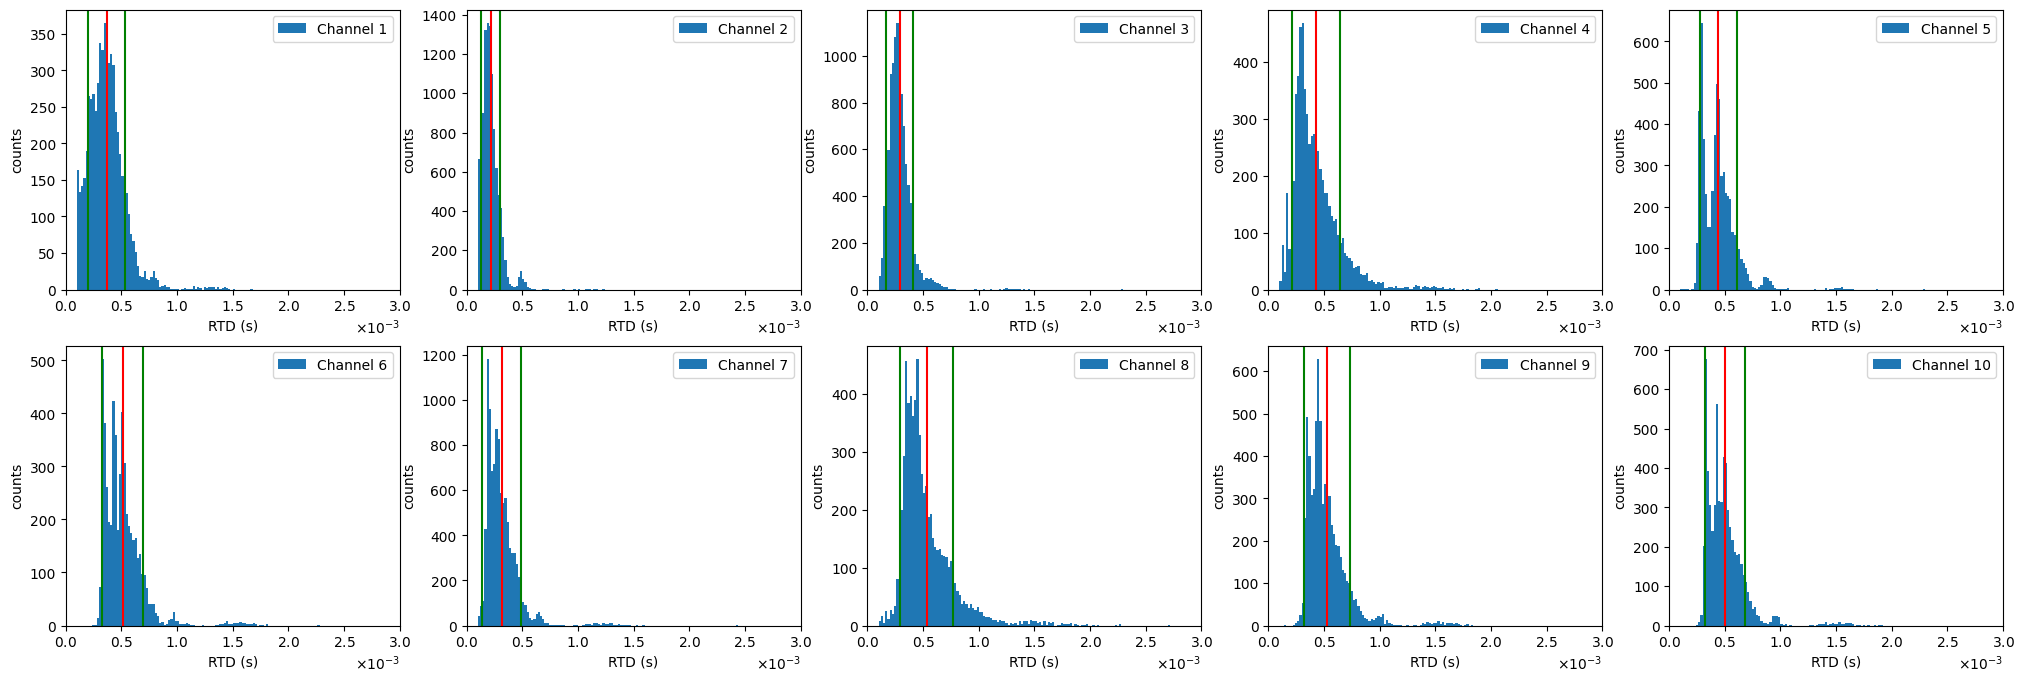

In [5]:
###########################################################################
########## Calculate the distribution of RTDs and graph it   ##############
###########################################################################

# create a list of the channels and all of their resets
chResets = [[t for t, mask in zip(time_sec, masks) if m(ch, mask)] for ch in range(saq.N_SAQ_CHANNELS)]

#calculate the time between resets for each channel
rtd = [ [] for _ in range(saq.N_SAQ_CHANNELS)]
mask = [ [] for _ in range(saq.N_SAQ_CHANNELS)]  # RTDs to ignore
mean = np.zeros(saq.N_SAQ_CHANNELS) 
std  = np.zeros(saq.N_SAQ_CHANNELS)
for ch in range(saq.N_SAQ_CHANNELS):
    rtd[ch] = np.zeros(len(chResets[ch]))
    mask[ch] = np.zeros(len(chResets[ch]))

fig, axs = plt.subplots(2,5, figsize=(25,8))
    
for ch in range(10): # only calibrated first 10 channels...
    for r in range(len(chResets[ch])-1):
        prev = chResets[ch][r+1]
        curr = chResets[ch][r]
        rtd[ch][r] = prev - curr

    lower_bound = 1e-4 # low cut at 0.1 ms 
    upper_bound = 1e-2 # high cut at 10 ms
    mask = (rtd[ch] >= lower_bound) & (rtd[ch] <= upper_bound)
    mean[ch] = np.mean(rtd[ch][mask])
    std[ch] = np.std(rtd[ch][mask])
    #std[ch] = np.std(rtd[ch])

    print("ch", ch+1, " ,mean: ",  mean[ch], " ,std: ", std[ch])

    row = int(ch/5)
    col = ch%5
    axs[row,col].hist(rtd[ch][mask], range=(0, 0.01), bins = 500, label=f'Channel {ch+1}')
    #axs[row,col].hist(rtd[ch], bins = 100)
    axs[row,col].axvline(mean[ch], color = 'red')
    axs[row,col].axvline(mean[ch]-std[ch] , color = 'green')
    axs[row,col].axvline(mean[ch]+std[ch] , color = 'green')

    # Configure the x-axis formatter to use scientific notation
    axs[row, col].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axs[row, col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))  # Apply scientific notation

     # Add titles (labels) to x and y axes
    axs[row, col].set_xlabel('RTD (s)')  # Replace with your desired x-axis label
    axs[row, col].set_ylabel('counts')  # Replace with your desired y-axis label

    # Define your desired x-axis range
    x_min = 0  # Replace with your desired minimum x-axis value
    x_max = 0.003  # Replace with your desired maximum x-axis value

     # Set the x-axis range
    axs[row, col].set_xlim(x_min, x_max)
    #axs[row, col].set_yscale('log')
    axs[row, col].legend()


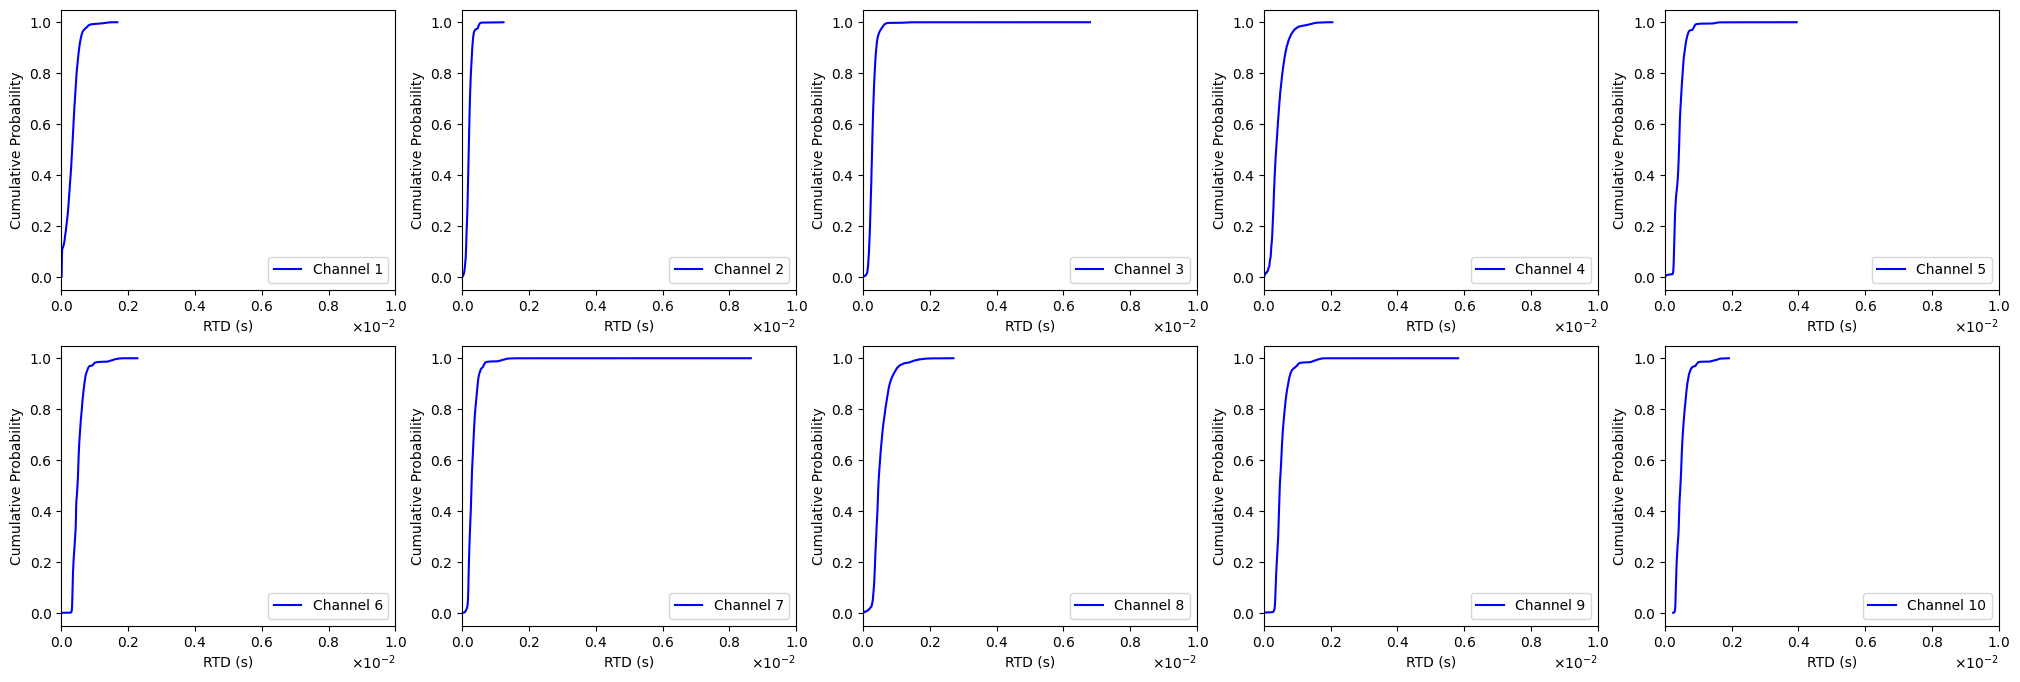

In [6]:
# Create a new figure for the cumulative histograms
fig, axs = plt.subplots(2, 5, figsize=(25, 8))

for ch in range(10): # only calibrated first 10 channels...
    for r in range(len(chResets[ch])-1):
        prev = chResets[ch][r+1]
        curr = chResets[ch][r]
        rtd[ch][r] = prev - curr

    lower_bound = 1e-5 # low cut at 0.1 ms 
    upper_bound = 1e-2 # high cut at 10 ms
    mask = (rtd[ch] >= lower_bound) & (rtd[ch] <= upper_bound)
    mean[ch] = np.mean(rtd[ch][mask])

    std[ch] = np.std(rtd[ch][mask])

    # Calculate the cumulative distribution
    sorted_rtd = np.sort(rtd[ch][mask])
    cumulative_prob = np.arange(1, len(sorted_rtd) + 1) / len(sorted_rtd)

    row = int(ch / 5)
    col = ch % 5

    axs[row, col].plot(sorted_rtd, cumulative_prob, color='blue', label=f'Channel {ch+1}')

    # Add labels and a title
    axs[row, col].set_xlabel('RTD (s)')
    axs[row, col].set_ylabel('Cumulative Probability')
    #axs[row, col].set_title(f'Channel {ch}')

    # Configure the x-axis formatter to use scientific notation
    axs[row, col].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    axs[row, col].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    # Define your desired x-axis range
    x_min = 0  # Replace with your desired minimum x-axis value
    x_max = 0.01  # Replace with your desired maximum x-axis value

    # Set the x-axis range
    axs[row, col].set_xlim(x_min, x_max)
    axs[row,col].legend(loc='lower right')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1.60167106 1.03568241 1.43510032 2.09146388 2.18963333 2.56412873
 1.57573515 2.64335689 2.63764074 2.50585449]
[0.97450171 0.44151503 0.62807337 1.10125711 0.84761762 0.92596738
 0.87044928 1.20692589 1.03350458 0.91067731]
The average charege per reset is:  2.0280266995845047 pC


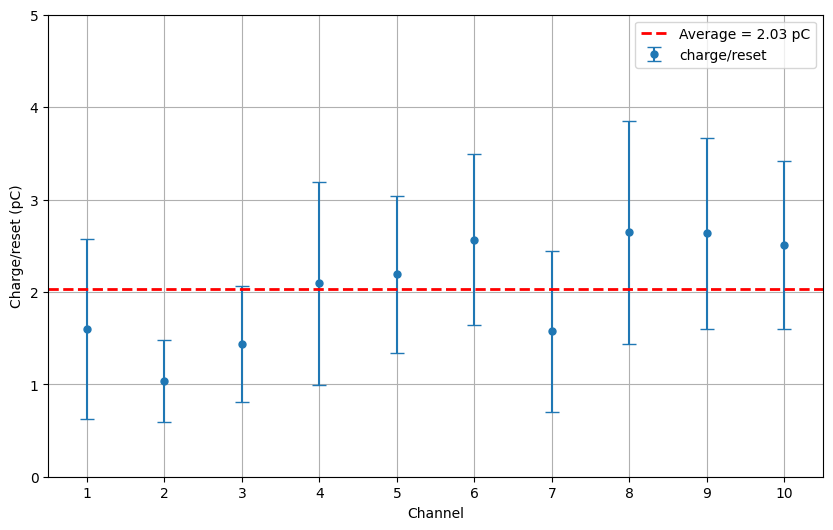

In [25]:
# Define the range of channels to plot
start_channel = 1  # Start channel
end_channel = 10  # End channel

# Create a list of channel numbers within the specified range
channels = list(range(start_channel, end_channel+1))
print(channels)

# Extract mean and std values of charge per reset for the specified channels
mean_charge = mean[start_channel - 1:end_channel] * 5000 # convert rtd in seconds to charge in pC by multiplying 5000 pA
std_charge = std[start_channel - 1:end_channel] * 5000 # covert the sigma from time to charge by multiplying the current

print(mean_charge)
print(std_charge)
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the average charge per reset with error bars
ax.errorbar(channels, mean_charge, yerr=std_charge, fmt='o', markersize=5, capsize=5, label='charge/reset')

# Calculate the average charge of the mean rtd for 10 channels
avg_charge = np.mean(mean_charge) #average charge = average rtd in second* 5 nA

# Plot a flat line at the calculated average value
ax.axhline(avg_charge, color='red', linestyle='--', label='Average = 2.03 pC', linewidth=2)
print("The average charege per reset is: ", avg_charge, "pC")

# Configure the x-axis formatter to use integers
ax.set_xticks(channels)

# Add labels to x and y axes
ax.set_xlabel('Channel')
ax.set_ylabel('Charge/reset (pC)')

# Set the x-axis and y-axis range and labels
ax.set_xlim(start_channel-0.5 , end_channel+0.5)
ax.set_ylim(0, 5)  
ax.grid(True)

# Show the legend
ax.legend()

# Show the plot
plt.show()

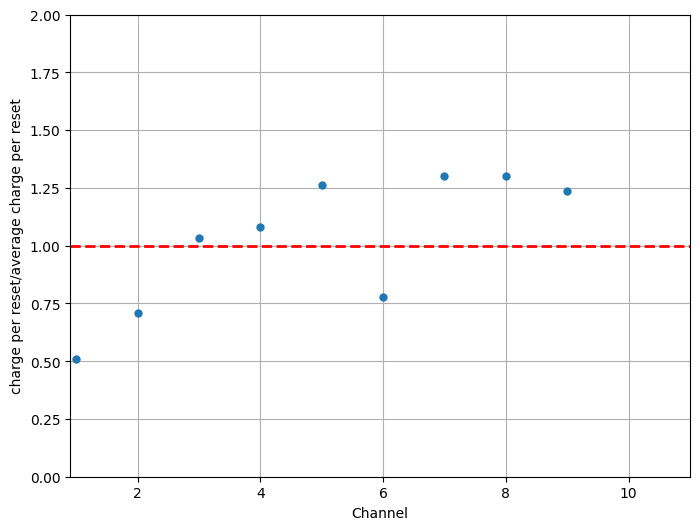

In [8]:
# Plot the first column (X-axis) vs. the second column (Y-axis) as data points
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(new_channels, mean_charge/avg_charge, 'o', markersize=5)
# Plot a flat line at the calculated average value
plt.axhline(y=1, color='red', linestyle='--', label='Average', linewidth=2)
plt.xlabel('Channel')
plt.ylabel('charge per reset/average charge per reset')
plt.xlim(start_channel - 0.1, end_channel + 1)
plt.ylim(0, 2)
plt.grid(True)
plt.show()


In [9]:
data1 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData1.csv", sep=',', skiprows=1)
data2 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData2.csv", sep=',', skiprows=1)
data3 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData3.csv", sep=',', skiprows=1)
data4 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData4.csv", sep=',', skiprows=1)
data5 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData5.csv", sep=',', skiprows=1)
data6 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData6.csv", sep=',', skiprows=1)
data7 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData7.csv", sep=',', skiprows=1)
data8 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData8.csv", sep=',', skiprows=1)
data9 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData9.csv", sep=',', skiprows=1)
data10 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData10.csv", sep=',', skiprows=1)
data11 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData11.csv", sep=',', skiprows=1)
data12 = pd.read_csv("/home/wwz/saq_analysis/calibration/pressure_scan/pressureData12.csv", sep=',', skiprows=1)
data1.head(16)

,1.0,10.879732445619698,14.0
0,2.0,5.564211,31.0
1,3.0,7.247767,61.0
2,4.0,7.287994,108.0
3,5.0,7.485010,171.0
4,6.0,5.352097,154.0
5,7.0,4.418165,158.0
6,8.0,3.388478,216.0
7,9.0,2.663981,208.0
8,10.0,0.454888,74.0
9,11.0,0.082985,36.0


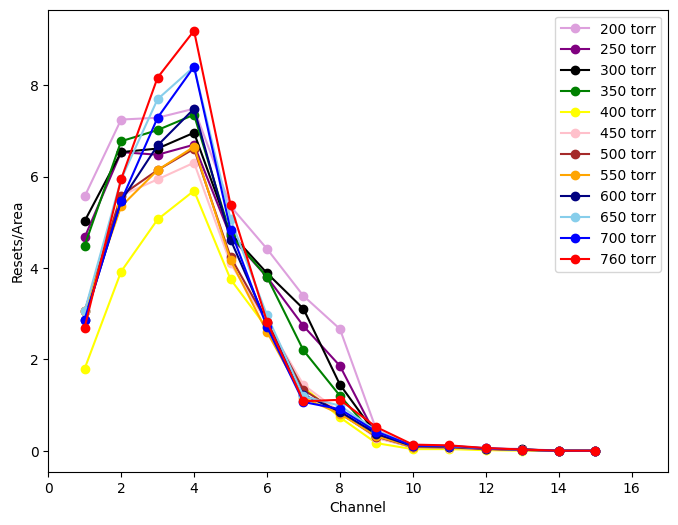

In [10]:
# Plot the first column (X-axis) vs. the second column (Y-axis) as data points
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(data1.iloc[:, 0]-1, data1.iloc[:, 1], marker='o', color='plum', label='200 torr')
plt.plot(data2.iloc[:, 0]-1, data2.iloc[:, 1], marker='o', color='purple', label='250 torr')
plt.plot(data3.iloc[:, 0]-1, data3.iloc[:, 1], marker='o', color='black', label='300 torr')
plt.plot(data4.iloc[:, 0]-1, data4.iloc[:, 1], marker='o', color='green', label='350 torr')
plt.plot(data5.iloc[:, 0]-1, data5.iloc[:, 1], marker='o', color='yellow', label='400 torr')
plt.plot(data6.iloc[:, 0]-1, data6.iloc[:, 1], marker='o', color='pink', label='450 torr')
plt.plot(data7.iloc[:, 0]-1, data7.iloc[:, 1], marker='o', color='brown', label='500 torr')
plt.plot(data8.iloc[:, 0]-1, data8.iloc[:, 1], marker='o', color='orange', label='550 torr')
plt.plot(data9.iloc[:, 0]-1, data9.iloc[:, 1], marker='o', color='navy', label='600 torr')
plt.plot(data10.iloc[:, 0]-1, data10.iloc[:, 1], marker='o', color='skyblue', label='650 torr')
plt.plot(data11.iloc[:, 0]-1, data11.iloc[:, 1], marker='o', color='blue', label='700 torr')
plt.plot(data12.iloc[:, 0]-1, data12.iloc[:, 1], marker='o', color='red', label='760 torr')
plt.xlabel('Channel')
plt.ylabel('Resets/Area')
plt.xlim(0, 17)
#plt.yscale('log')
#plt.grid(True)
plt.legend()
plt.show()

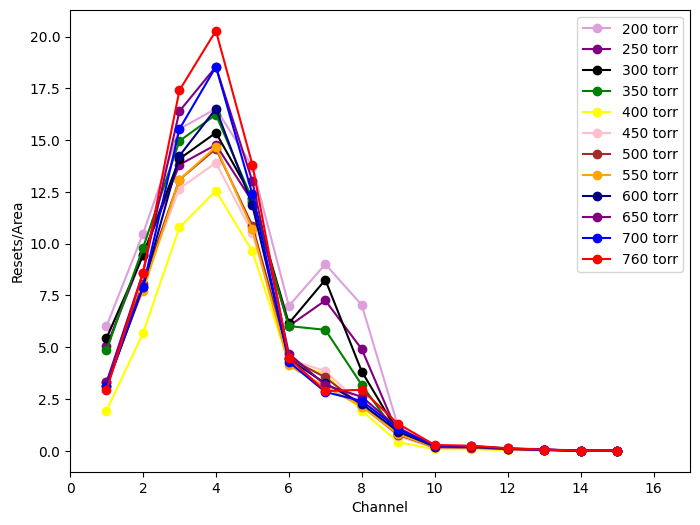

In [11]:
# Plot the first column (X-axis) vs. the second column (Y-axis) as data points
charge_per_reset=[1.081, 1.446, 2.132, 2.207, 2.565, 1.583, 2.659, 2.641, 2.506, 2.066, 2.066, 2.066, 2.066, 2.066, 2.066] # use the average charge per reset value for the last 6 channels
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.plot(data1.iloc[:, 0]-1, data1.iloc[:, 1]*charge_per_reset, marker='o', color='plum', label='200 torr')
plt.plot(data2.iloc[:, 0]-1, data2.iloc[:, 1]*charge_per_reset, marker='o', color='purple', label='250 torr')
plt.plot(data3.iloc[:, 0]-1, data3.iloc[:, 1]*charge_per_reset, marker='o', color='black', label='300 torr')
plt.plot(data4.iloc[:, 0]-1, data4.iloc[:, 1]*charge_per_reset, marker='o', color='green', label='350 torr')
plt.plot(data5.iloc[:, 0]-1, data5.iloc[:, 1]*charge_per_reset, marker='o', color='yellow', label='400 torr')
plt.plot(data6.iloc[:, 0]-1, data6.iloc[:, 1]*charge_per_reset, marker='o', color='pink', label='450 torr')
plt.plot(data7.iloc[:, 0]-1, data7.iloc[:, 1]*charge_per_reset, marker='o', color='brown', label='500 torr')
plt.plot(data8.iloc[:, 0]-1, data8.iloc[:, 1]*charge_per_reset, marker='o', color='orange', label='550 torr')
plt.plot(data9.iloc[:, 0]-1, data9.iloc[:, 1]*charge_per_reset, marker='o', color='navy', label='600 torr')
plt.plot(data10.iloc[:, 0]-1, data10.iloc[:, 1]*charge_per_reset, marker='o', color='purple', label='650 torr')
plt.plot(data11.iloc[:, 0]-1, data11.iloc[:, 1]*charge_per_reset, marker='o', color='blue', label='700 torr')
plt.plot(data12.iloc[:, 0]-1, data12.iloc[:, 1]*charge_per_reset, marker='o', color='red', label='760 torr')
#print(data.iloc[:, 1]*charge_per_reset)
plt.xlabel('Channel')
plt.ylabel('Resets/Area')
plt.xlim(0, 17)
#plt.yscale('log')
#plt.grid(True)
plt.legend()
plt.show()

In [16]:
data_frames = []

for i in range(1, 13):
    file_name = f"/home/wwz/saq_analysis/calibration/pressure_scan/pressureData{i}.csv"
    df = pd.read_csv(file_name, delimiter=",", skiprows={1, 15, 16})
    data_frames.append(df)

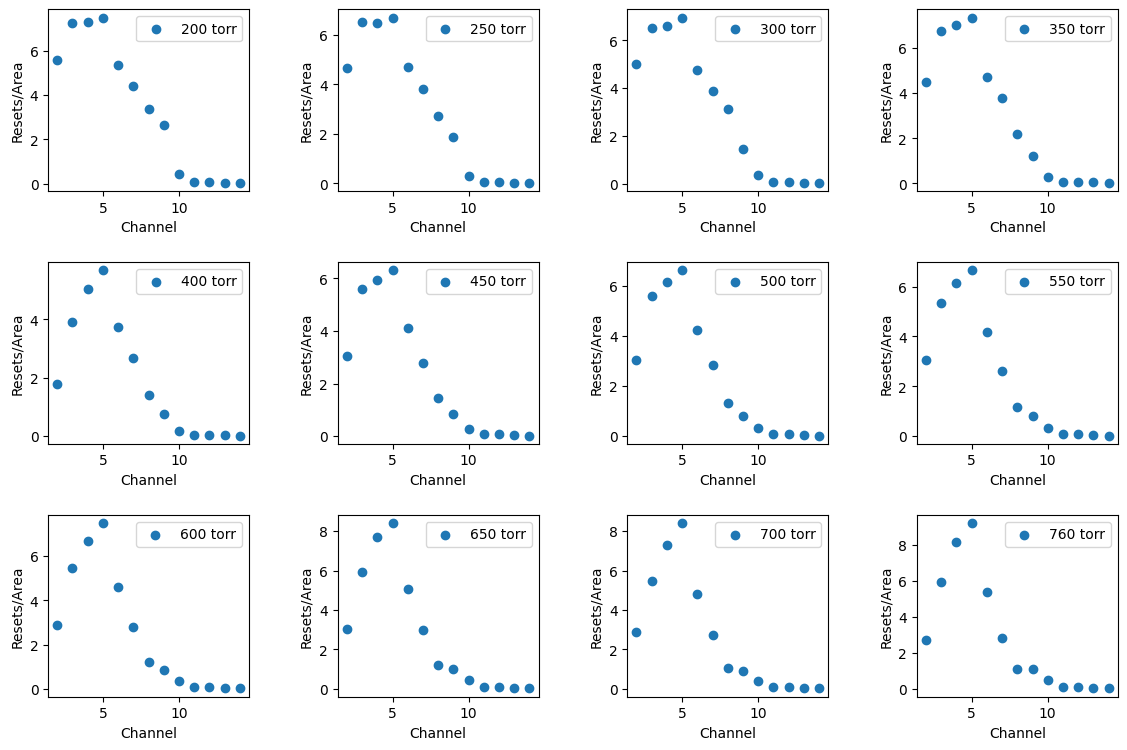

In [29]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
fig.tight_layout(pad=3.0)

pressures = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 760]

for i, (df, pressure) in enumerate(zip(data_frames, pressures)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    ax.scatter(df.iloc[:, 0], df.iloc[:, 1], label= f'{pressure} torr')
    #ax.set_title(f'Distribution {i+1}')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Resets/Area')
    #ax.set_ylim(0, 8)
    ax.legend()


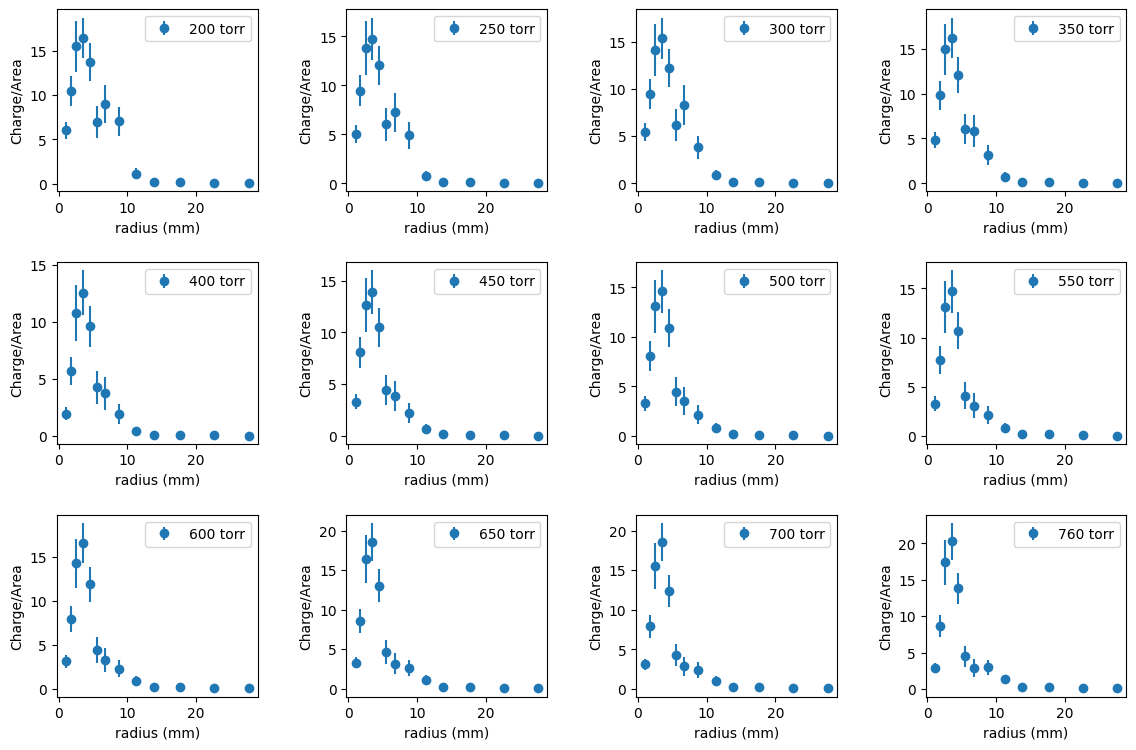

In [35]:
charge_per_reset=[1.081, 1.446, 2.132, 2.207, 2.565, 1.583, 2.659, 2.641, 2.506, 2.066, 2.066, 2.066, 2.066]
new_err=[0.41657048, 0.62115702, 1.07734384, 0.83083259, 0.92542819, 0.86818807, 1.1950613, 1.02980175, 0.91067731, 0, 0, 0, 0]

fig, axes = plt.subplots(3, 4, figsize=(12, 8))
fig.tight_layout(pad=3.0)

pressures = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 760]

for i, (df, pressure) in enumerate(zip(data_frames, pressures)):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    #ax.scatter(df.iloc[:, 0], df.iloc[:, 1]*charge_per_reset, label= f'{pressure} torr') # charge/area vs. channels
    #ax.scatter(saq.radius_of_channel[1:-4], df.iloc[:, 1]*charge_per_reset, label= f'{pressure} torr') # charge/area vs. radius without errors
    ax.errorbar(saq.radius_of_channel[1:-2], df.iloc[:, 1]*charge_per_reset, yerr=df.iloc[:, 1]**(0.5)*new_err, fmt='o', label= f'{pressure} torr') # charge/area vs. radius with errors
    #ax.errorbar(saq.radius_of_channel[1:-4], df.iloc[:, 1]*charge_per_reset, yerr=df.iloc[:, 1]*new_err, fmt='o', label= f'{pressure} torr') # charge/area vs. radius with errors
    ax.set_xlabel('radius (mm)')
    ax.set_ylabel('Charge/Area')
    ax.legend()

In [15]:
radius_data = saq.radius_of_channel
new_radius = radius_data[1:-4]
print(new_radius)

[ 1.08855317  1.78272712  2.58085228  3.53032477  4.52659149  5.52812179
  6.78769423  8.82738345 11.31492477 13.81784241 17.68517098]
